In [59]:
!pip install vaderSentiment
!pip install transformers==4.23.1
!pip install torch
!pip install functools
!pip install accelerate

  Using cached functools-0.5.tar.gz (4.9 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for functools
  Running setup.py clean for functools
Failed to build functools
ERROR: Could not build wheels for functools, which is required to install pyproject.toml-based projects


In [60]:
from google.colab import drive

import pandas as pd
import matplotlib.pyplot as plt
from nltk import tokenize
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import torch
from torch import nn
import torch
import torch.nn as nn
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import AutoTokenizer, TrainingArguments, Trainer, DistilBertConfig, DistilBertForSequenceClassification, BertConfig
from sklearn.metrics import f1_score, precision_recall_fscore_support, accuracy_score
from functools import partial
import accelerate

In [61]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [62]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


# Load Data

In [63]:
# Mount Google Drive
drive.mount('/content/gdrive')

# Define the file path
path = "/content/gdrive/MyDrive/Advanced ML/2020articles_cleaned_forsentiment.csv"

# Load data
full_df = pd.read_csv(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [64]:
# # Create a sample of articles with COVID in the title
# df = full_df[full_df['title'].str.contains('covid', case=False)]

In [65]:
full_df.columns

Index(['Unnamed: 0', 'uuid', 'source', 'year', 'article_text', 'title',
       'full_article_text', 'title_text'],
      dtype='object')

In [66]:
df = full_df.sample(n=20000)
df = df.loc[:,['uuid', 'title_text']]

In [67]:
len(df)

20000

In [68]:
# df.head(1)

# Sentiment Analysis

### Make labels using Vader

In [69]:
def calculate_average_sentiment(paragraph): # adding to Jackie's function
    analyzer = SentimentIntensityAnalyzer()
    # create sentence list
    sentence_list = tokenize.sent_tokenize(paragraph)
    #print(len(sentence_list),sentence_list)
    paragraph_sentiments = 0.0
    for sentence in sentence_list:
        vs = analyzer.polarity_scores(sentence)
        paragraph_sentiments += vs["compound"]

    # the average sentiment
    average_sentiment = paragraph_sentiments / len(sentence_list)

    # categorize sentiment
    if average_sentiment >= 0.5:
      return 5
    elif average_sentiment >= 0.3:
      return 4
    elif average_sentiment <= -0.5:
      return 2
    elif average_sentiment <= -0.3:
      return 1
    else:
      return 3

In [70]:
df['sentiment_score'] = df['title_text'].apply(calculate_average_sentiment)
df = df[df['sentiment_score'].notna()]

In [71]:
df[:1]

,uuid,title_text,sentiment_score
3885,2121958f-3da7-11ee-a96e-33dec8f414a2,FiveThirtyEight Gives Biden 71% Chance Of Vict...,4


In [72]:
# Get counts for each unique value in the 'Category' column
value_counts = df['sentiment_score'].value_counts()

# Create a new DataFrame to represent the table
table_df = pd.DataFrame({'VADER Sentiment Score': value_counts.index, 'Count': value_counts.values})
table_df['Percentage'] = (table_df['Count']/len(df)).round(4)

# Display the resulting table
table_df

,VADER Sentiment Score,Count,Percentage
0,3,14839,0.7420
1,1,1969,0.0984
2,4,1785,0.0892
3,2,845,0.0422
4,5,562,0.0281


### Split Data



In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['title_text'], df['sentiment_score'], test_size=0.2)

In [74]:
X_train[:1].to_list()

['SI Board Facing Significant Changes After Blue Lives Matter Ad. Two large shareholders of Maven, the company that publishes Sports Illustrated (SI), filed papers last week to fire five of the companys seven directors, with the aim of replacing the board with one that better “reflects the new Maven,” according to documents from the Securities and Exchange Commission. “The board members under attack joined the company under former CEO James Heckman,\xa0who was replaced\xa0earlier this year amid controversy over major staff cuts at SI and the companys\xa0hosting of a Blue Lives ']

In [75]:
# y_train[:1]

In [76]:
# Load the DistilBERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# The dataset class
class TheDataset(torch.utils.data.Dataset):

    def __init__(self, texts, sentiments, tokenizer):
        self.texts = texts
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.max_len = tokenizer.model_max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        sentiments = self.sentiments[index]

        encoded_text = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
            padding="max_length",
            truncation=True
        )

        return {
            'input_ids': encoded_text['input_ids'][0],
            'attention_mask': encoded_text['attention_mask'][0],
            'labels': torch.tensor(sentiments, dtype=torch.long) - 1  # Adjust labels to start from 0
        }

# Prepare the Train/Validation sets
train_set_dataset = TheDataset(
    texts=X_train.tolist(),
    sentiments=y_train.tolist(),
    tokenizer=tokenizer,
)

valid_set_dataset = TheDataset(
    texts=X_test.tolist(),
    sentiments=y_test.tolist(),
    tokenizer=tokenizer,
)

# Load the DistilBERT model
config = DistilBertConfig.from_pretrained("distilbert-base-uncased")
config.num_labels = 5
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

# Initialize the bias and weight for the classifier layer
model.classifier.bias.data.fill_(0)
model.classifier.weight.data.normal_(mean=0.0, std=0.02)

# The function to get the accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')  # Change average to 'weighted'
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define the training parameters
training_args = TrainingArguments(
    output_dir="./sentiment-analysis",
    num_train_epochs=3,
    per_device_train_batch_size=16,  # Change back to 64 if resources allow
    per_device_eval_batch_size=64,
    warmup_steps=30,
    weight_decay=0.01,
    save_strategy="epoch",
    evaluation_strategy="steps"
)

# Define trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set_dataset,
    eval_dataset=valid_set_dataset,
    compute_metrics=compute_metrics
)

# Start pre-training!
trainer.train()


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.23.1",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.753900,0.630716,0.751000,0.725087,0.708302,0.751000
1000,0.566100,0.514297,0.799750,0.786675,0.781031,0.799750
1500,0.379300,0.501745,0.809250,0.801714,0.809622,0.809250
2000,0.352900,0.437180,0.823250,0.820287,0.825735,0.823250
2500,0.181300,0.574748,0.822500,0.822728,0.826405,0.822500
3000,0.181000,0.578601,0.828750,0.826200,0.826891,0.828750


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 64
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 64
Saving model checkpoint to ./sentiment-analysis/checkpoint-1000
Configuration saved in ./sentiment-analysis/checkpoint-1000/config.json
Model weights saved in ./sentiment-analysis/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 64
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 64
Saving model checkpoint to ./sentiment-analysis/checkpoint-2000
Configuration saved in ./sentiment-analysis/checkpoint-2000/config.json
Model weights saved in ./sentiment-analysis/checkpoint

TrainOutput(global_step=3000, training_loss=0.40241532389322915, metrics={'train_runtime': 915.878, 'train_samples_per_second': 52.409, 'train_steps_per_second': 3.276, 'total_flos': 6358775316480000.0, 'train_loss': 0.40241532389322915, 'epoch': 3.0})

In [77]:
# Evaluate the model on the validation set
results = trainer.evaluate()

# Print the evaluation results
print("Evaluation Results:", results)

***** Running Evaluation *****
  Num examples = 4000
  Batch size = 64


Evaluation Results: {'eval_loss': 0.5786010026931763, 'eval_accuracy': 0.82875, 'eval_f1': 0.8261998804110827, 'eval_precision': 0.826890819091449, 'eval_recall': 0.82875, 'eval_runtime': 22.0035, 'eval_samples_per_second': 181.789, 'eval_steps_per_second': 2.863, 'epoch': 3.0}


In [78]:
# Save a fine-tuned model
model_save_directory = "/content/gdrive/MyDrive/model_save_directory/title_text_sentiment_bert_1000"
trainer.save_model(model_save_directory)

Saving model checkpoint to /content/gdrive/MyDrive/model_save_directory/title_text_sentiment_bert_1000
Configuration saved in /content/gdrive/MyDrive/model_save_directory/title_text_sentiment_bert_1000/config.json
Model weights saved in /content/gdrive/MyDrive/model_save_directory/title_text_sentiment_bert_1000/pytorch_model.bin


In [79]:
# New text for prediction
new_text = 'off the rails: moderators struggle as 10th democratic debate turns into absolute shouting match'

# Tokenize the new text
inputs = tokenizer(new_text, return_tensors='pt')

# Move input tensors to the same device as the model
inputs = {key: value.to(model.device) for key, value in inputs.items()}

# Forward pass through the trained model
with torch.no_grad():
    outputs = model(**inputs)

# Get predicted probabilities and labels
probs = torch.softmax(outputs.logits, dim=-1)
predicted_class = torch.argmax(probs)

# Convert the predicted class index to a human-readable label
label_map = {0: 'Negative', 1: 'Somewhat Negative', 2: 'Neutral', 3: 'Somewhat Positive', 4: 'Positive'}
predicted_label = label_map[predicted_class.item()]

print(f"Predicted Label: {predicted_label}")


Predicted Label: Negative


In [80]:
# New text for prediction
new_text = 'crisis averted as senate passes spending bill'

# Tokenize the new text
inputs = tokenizer(new_text, return_tensors='pt')

# Move input tensors to the same device as the model
inputs = {key: value.to(model.device) for key, value in inputs.items()}

# Forward pass through the trained model
with torch.no_grad():
    outputs = model(**inputs)

# Get predicted probabilities and labels
probs = torch.softmax(outputs.logits, dim=-1)
predicted_class = torch.argmax(probs)

# Convert the predicted class index to a human-readable label
label_map = {0: 'Negative', 1: 'Somewhat Negative', 2: 'Neutral', 3: 'Somewhat Positive', 4: 'Positive'}
predicted_label = label_map[predicted_class.item()]

print(f"Predicted Label: {predicted_label}")

Predicted Label: Somewhat Negative


In [82]:
# New text for prediction
new_text = 'Cory Booker: Clearly Amy Coney Barrett Is Not a Racist'

# Tokenize the new text
inputs = tokenizer(new_text, return_tensors='pt')

# Move input tensors to the same device as the model
inputs = {key: value.to(model.device) for key, value in inputs.items()}

# Forward pass through the trained model
with torch.no_grad():
    outputs = model(**inputs)

# Get predicted probabilities and labels
probs = torch.softmax(outputs.logits, dim=-1)
predicted_class = torch.argmax(probs)

# Convert the predicted class index to a human-readable label
label_map = {0: 'Negative', 1: 'Somewhat Negative', 2: 'Neutral', 3: 'Somewhat Positive', 4: 'Positive'}
predicted_label = label_map[predicted_class.item()]

print(f"Predicted Label: {predicted_label}")

Predicted Label: Neutral


In [83]:
# New text for prediction
new_text = 'Coronavirus splits U.S. along party lines'

# Tokenize the new text
inputs = tokenizer(new_text, return_tensors='pt')

# Move input tensors to the same device as the model
inputs = {key: value.to(model.device) for key, value in inputs.items()}

# Forward pass through the trained model
with torch.no_grad():
    outputs = model(**inputs)

# Get predicted probabilities and labels
probs = torch.softmax(outputs.logits, dim=-1)
predicted_class = torch.argmax(probs)

# Convert the predicted class index to a human-readable label
label_map = {0: 'Negative', 1: 'Somewhat Negative', 2: 'Neutral', 3: 'Somewhat Positive', 4: 'Positive'}
predicted_label = label_map[predicted_class.item()]

print(f"Predicted Label: {predicted_label}")

Predicted Label: Somewhat Positive


In [99]:
# New text for prediction
new_text = 'Delingpole: Meghan Markle Is NOT a Victim of Racism'

# Tokenize the new text
inputs = tokenizer(new_text, return_tensors='pt')

# Move input tensors to the same device as the model
inputs = {key: value.to(model.device) for key, value in inputs.items()}

# Forward pass through the trained model
with torch.no_grad():
    outputs = model(**inputs)

# Get predicted probabilities and labels
probs = torch.softmax(outputs.logits, dim=-1)
predicted_class = torch.argmax(probs)

# Convert the predicted class index to a human-readable label
label_map = {0: 'Negative', 1: 'Somewhat Negative', 2: 'Neutral', 3: 'Somewhat Positive', 4: 'Positive'}
predicted_label = label_map[predicted_class.item()]

print(f"Predicted Label: {predicted_label}") # changes from somewhat negative in VADER

Predicted Label: Positive


In [100]:
# New text for prediction
new_text = 'Mark Warner: Stupidity on steroids not to pass emergency coronavirus relief before Christmas'

# Tokenize the new text
inputs = tokenizer(new_text, return_tensors='pt')

# Move input tensors to the same device as the model
inputs = {key: value.to(model.device) for key, value in inputs.items()}

# Forward pass through the trained model
with torch.no_grad():
    outputs = model(**inputs)

# Get predicted probabilities and labels
probs = torch.softmax(outputs.logits, dim=-1)
predicted_class = torch.argmax(probs)

# Convert the predicted class index to a human-readable label
label_map = {0: 'Negative', 1: 'Somewhat Negative', 2: 'Neutral', 3: 'Somewhat Positive', 4: 'Positive'}
predicted_label = label_map[predicted_class.item()]

print(f"Predicted Label: {predicted_label}") # change from Somewhat positive in Vader model

Predicted Label: Negative


In [102]:
# New text for prediction
new_text = 'Donald Trump: Facts Are on Our Side in Election Fight, but Time Isnt'

# Tokenize the new text
inputs = tokenizer(new_text, return_tensors='pt')

# Move input tensors to the same device as the model
inputs = {key: value.to(model.device) for key, value in inputs.items()}

# Forward pass through the trained model
with torch.no_grad():
    outputs = model(**inputs)

# Get predicted probabilities and labels
probs = torch.softmax(outputs.logits, dim=-1)
predicted_class = torch.argmax(probs)

# Convert the predicted class index to a human-readable label
label_map = {0: 'Negative', 1: 'Somewhat Negative', 2: 'Neutral', 3: 'Somewhat Positive', 4: 'Positive'}
predicted_label = label_map[predicted_class.item()]

print(f"Predicted Label: {predicted_label}") # change from neutral in Vader model

Predicted Label: Negative


## Load Saved Model

In [84]:
# To reload a saved model
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model_save_directory = "/content/gdrive/MyDrive/model_save_directory/title_sentiment_bert_20000_fullyprocessed"
model = DistilBertForSequenceClassification.from_pretrained(model_save_directory)
print(model)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.23.1",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [92]:
full_df['vader_sentiment_score'] = full_df['title'].apply(calculate_average_sentiment)
full_df = full_df[full_df['vader_sentiment_score'].notna()]

In [93]:
def bert_sentiment(text, tokenizer, model):

  # Tokenize the new text
  inputs = tokenizer(text, return_tensors='pt')

  # Move input tensors to the same device as the model
  inputs = {key: value.to(model.device) for key, value in inputs.items()}

  # Forward pass through the trained model
  with torch.no_grad():
      outputs = model(**inputs)

  # Get predicted probabilities and labels
  probs = torch.softmax(outputs.logits, dim=-1)
  predicted_class = torch.argmax(probs)

  return predicted_class.item() + 1 # add one to standardize to 5 point scale

In [94]:
full_df['bert_sentiment_score'] = full_df['title'].apply(lambda x: bert_sentiment(x, tokenizer, model))

In [95]:
# Get counts for each unique value in the 'Category' column
value_counts = full_df['vader_sentiment_score'].value_counts()

# Create a new DataFrame to represent the table
table_df = pd.DataFrame({'VADER Sentiment Score': value_counts.index, 'Count': value_counts.values})
table_df['Percentage'] = (table_df['Count']/len(df)).round(4)

# Display the resulting table
table_df

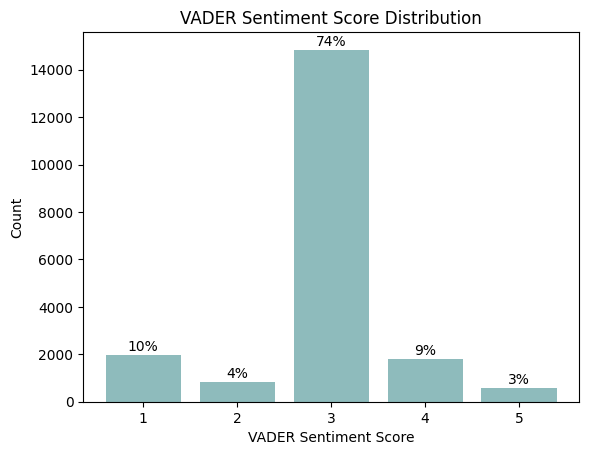

In [96]:
# Create a bar chart
plt.bar(table_df['VADER Sentiment Score'], table_df['Count'], color='cadetblue', alpha=0.7, label='Count')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('Count')
plt.title('VADER Sentiment Score Distribution')

# Add percentage labels to each bar
for i, val in enumerate(table_df['Percentage']):
    plt.text(table_df['VADER Sentiment Score'][i], table_df['Count'][i] + 50, f'{val:.0%}', ha='center', va='bottom')

# Show the plot
plt.show()

In [97]:
# Get counts for each unique value in the 'Category' column
value_counts = full_df['bert_sentiment_score'].value_counts()

# Create a new DataFrame to represent the table
table_df = pd.DataFrame({'BERT Sentiment Score': value_counts.index, 'Count': value_counts.values})
table_df['Percentage'] = (table_df['Count']/len(df)).round(4)

# Display the resulting table
table_df

,BERT Sentiment Score,Count,Percentage
0,3,18947,0.9474
1,2,6122,0.3061
2,1,4563,0.2282
3,4,4019,0.2010
4,5,3384,0.1692


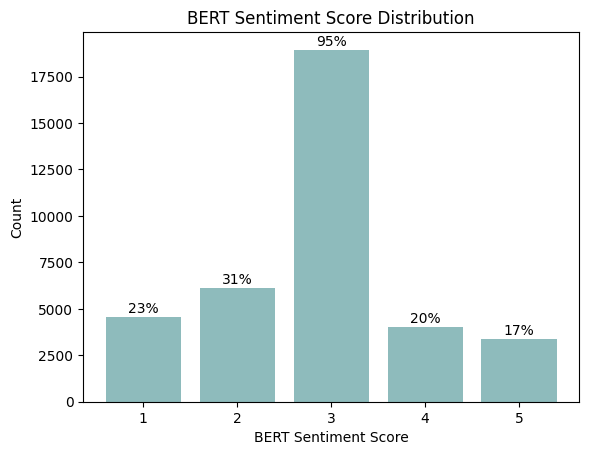

In [98]:
# Create a bar chart
plt.bar(table_df['BERT Sentiment Score'], table_df['Count'], color='cadetblue', alpha=0.7, label='Count')
plt.xlabel('BERT Sentiment Score')
plt.ylabel('Count')
plt.title('BERT Sentiment Score Distribution')

# Add percentage labels to each bar
for i, val in enumerate(table_df['Percentage']):
    plt.text(table_df['BERT Sentiment Score'][i], table_df['Count'][i] + 50, f'{val:.0%}', ha='center', va='bottom')

# Show the plot
plt.show()